In [1]:
import math
import os
import gc
import sys
import time

from pathlib import Path

from functools import partial
from typing import Callable, Dict, Iterator, List, Optional, Tuple, Union

from tqdm.notebook import tqdm

In [2]:
BASE_DIR = '/home/dmitry/projects/dfdc'
DATA_DIR = os.path.join(BASE_DIR, 'data/dfdc-videos')
HDF5_DIR = '/home/dmitry/projects/dfdc/data/dfdc-crops/hdf5'
IMG_DIR = '/home/dmitry/projects/dfdc/data/dfdc-crops/images'

In [3]:
import cv2
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
from torch import Tensor

In [4]:
# src
sys.path.insert(0, os.path.join(BASE_DIR, 'src'))
from dataset.utils import read_labels
from prepare_data import get_file_list

In [5]:
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [6]:
def check_len_hdf5(path):
    lens = dict()
    for name in os.listdir(path):
        full_path = os.path.join(path, name)
        if os.path.isfile(full_path):
            with h5py.File(full_path, 'r+') as f:
                lens[name] = len(f)
    return lens

In [7]:
# path = '/home/dmitry/projects/dfdc/data/dfdc-crops/hdf5/dfdc_train_part_17/'
# path += 'rbfvimgnid.h5'
# num_frames = 10
# sample_fn = partial(space_frames_evenly, num_frames)
# cols = math.ceil(num_frames / 6)
# faces = read_hdf5(path, num_frames=num_frames, sample_fn=sample_fn)        
# show_images(faces, cols=cols)

In [8]:
# png_lens = check_len_hdf5('/home/dmitry/projects/dfdc/data/dfdc-crops/hdf5/dfdc_train_part_49_png')

In [9]:
# webp_lens = check_len_hdf5('/home/dmitry/projects/dfdc/data/dfdc-crops/hdf5/dfdc_train_part_49')

In [10]:
# for key, length in webp_lens.items():
#     if png_lens[key] != length:
#         print(f'PNG: {png_lens[key]}')
#         print(f'WebP: {length}')

In [11]:
def find_num_frames(df, idxs):
    lens = []
    for idx in idxs:
        meta = df.iloc[idx]
        path = os.path.join(HDF5_DIR, meta.dir, meta.name[:-4]+'.h5')
        if os.path.isfile(path):
            with h5py.File(path, 'r+') as f:
                lens.append(len(f))
        else:
            lens.append(-1)
    return lens

In [12]:
def read_image_folder(path: str, num_frames: int, size: int,
                      sample_fn: Callable[[int], np.ndarray]) -> np.ndarray:
    img_size = (size, size)
    images = []
    
    files = sorted(os.listdir(path))
    total_frames = len(files)
    
    if total_frames > 0:
        idxs = sample_fn(total_frames)
        pick = create_mask(idxs, total_frames)
        for i, file in enumerate(files):
            if pick[i]:
                img_path = os.path.join(path, file)
                img = cv2.imread(img_path, cv2.IMREAD_COLOR)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size, 
                                 interpolation=cv2.INTER_NEAREST)
                images.append(img)
        return np.stack(images)
    else:
        return np.empty((0, size, size, 3), dtype=np.uint8)


def read_hdf5(path: str, num_frames: int, size: int,
              sample_fn: Callable[[int], np.ndarray]) -> np.ndarray:
    img_size = (size, size)
    images = []
    with h5py.File(path, 'r+') as file:
        total_frames = len(file)
        if total_frames > 0:
            idxs = sample_fn(total_frames)
            pick = create_mask(idxs, total_frames)
            for i, key in enumerate(file.keys()):
                if pick[i]:
                    img = np.uint8(file[key])
                    img = cv2.imdecode(img, cv2.IMREAD_COLOR)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, img_size, 
                                     interpolation=cv2.INTER_NEAREST)
                    images.append(img)
            return np.stack(images)
        else:
            return np.empty((0, size, size, 3), dtype=np.uint8)
        
        
def sparse_frames(n: int, total: int) -> np.ndarray:
    idxs = np.linspace(0, total, min(n, total), dtype=int, endpoint=False)
    rnd_shift = np.random.randint(0, (total - idxs[-1]))
    return idxs + rnd_shift


def rnd_slice_frames(n: int, total: int, stride=1.) -> np.ndarray:
    idxs = np.arange(0, total, stride)[:n].astype(np.uint16)
    rnd_shift = np.random.randint(0, (total - idxs[-1]))
    return idxs + rnd_shift


def create_mask(idxs: np.ndarray, total: int) -> np.ndarray:
    mask = np.zeros(total, dtype=np.bool)
    mask[idxs] = 1
    return mask


def pad(frames: np.ndarray, amount: int, where :str='start') -> np.ndarray:
    dims = np.zeros((frames.ndim, 2), dtype=np.int8)
    pad_dim = 1 if where == 'end' else 0
    dims[0, pad_dim] = amount
    return np.pad(frames, dims, 'constant')

In [13]:
class FrameSampler():
    def __init__(self, num_frames: int, real_fake_ratio: float, 
                 p_sparse: float):
        self.num_frames = num_frames
        self.real_fake_ratio = real_fake_ratio
        self.p_sparse = p_sparse
        
    def __call__(self, label: Tuple[int, bool]) -> Callable[[int], np.ndarray]:
        dice = np.random.rand()
        if dice < self.p_sparse:
            return partial(sparse_frames, self.num_frames)
        else:
            # Stored frames: fake - 30, real - 150, 
            # the real_fake_ratio should be set to 150 / 30 = 5
            # stride for fake: 5 - (4 * 1) = 1
            # stride for real: 5 - (4 * 0) = 5
            n = self.real_fake_ratio
            stride = n - ((n-1) * int(label))
            return partial(rnd_slice_frames, self.num_frames, stride=stride)

In [14]:
sampler = FrameSampler(num_frames=10, real_fake_ratio=100/30, p_sparse=0.)

In [15]:
sampler(label=1)(30)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint16)

In [16]:
sampler(label=0)(100)

array([ 1,  4,  7, 11, 14, 17, 21, 24, 27, 31], dtype=uint16)

In [17]:
frames = sampler(0)(125)
assert len(frames) == 10 
assert frames[-1] == frames[0] + (len(frames)-1) * 100/30
frames

array([10, 13, 16, 20, 23, 26, 30, 33, 36, 40], dtype=uint16)

In [18]:
sampler = FrameSampler(num_frames=10, real_fake_ratio=5, p_sparse=1.)

In [19]:
sampler(label=1)(30)

array([ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27])

In [20]:
sampler(label=False)(150)

array([ 14,  29,  44,  59,  74,  89, 104, 119, 134, 149])

In [21]:
class ImagesDataset(torch.utils.data.Dataset):
    def __init__(self, data_path: str, images_path: str, 
                 size: Tuple[int, int], sampler: FrameSampler):
        self.df = ImagesDataset._read_annotations(data_path, images_path)
        self.size = size
        self.images_path = images_path
        self.sampler = sampler
        
    @staticmethod
    def _read_annotations(data_path: str, images_path: str) -> pd.DataFrame:
        if not os.path.isdir(data_path):
            raise RuntimeError('Invalid data dir.. Wake up your drive brah!')
        parts = []
        for chunk_dir in os.listdir(data_path):
            chunk_path = Path(images_path)/chunk_dir
            if not chunk_path.is_dir():
                print('{}: dir is missing..'.format(chunk_path))
                continue
            meta_path = Path(data_path)/chunk_dir/'metadata.json'
            df = pd.read_json(meta_path).T
            df = df.reset_index().rename({'index': 'video'}, axis=1)
            df['label'] = df['label'] == 'FAKE'
            df['video'] = df['video'].apply(lambda vid: vid[:-4])
            df['dir'] = chunk_dir
            df['missing'] = False
            for i in range(len(df)):
                vid_dir = df.loc[i, 'video']
                path = chunk_path/vid_dir
                if not path.is_dir():
                    df.loc[i, 'missing'] = True
            num_miss = df['missing'].sum()
            if num_miss > 0:
                print('{}: {} videos missing..'.format(chunk_path, num_miss))
                df = df[~df['missing']]
            df.drop(['split', 'missing'], axis=1, inplace=True)
            parts.append(df)
        return pd.concat(parts)
        
    def __len__(self) :
        return len(self.df)
    
    def __getitem__(self, idx) -> Tuple[np.ndarray, int]:
        num_frames, size = self.size
        meta = self.df.iloc[idx]
        label = int(meta.label)
        path = os.path.join(self.images_path, meta.dir, meta.video)
        
        if os.path.isdir(path):
            sample_fn = self.sampler(meta.label)
            frames = read_image_folder(path, num_frames, size, 
                                       sample_fn=sample_fn)
        else:
            print('Dir not found: {}'.format(path))
            frames = np.zeros((num_frames, size, size, 3), dtype=np.uint8)
        
        if len(frames) > 0:
            pad_amount = num_frames - len(frames)
            if pad_amount > 0:
                frames = pad(frames, pad_amount, 'start')
        else:
            print('Empty file {}'.format(path))
            frames = np.zeros((num_frames, size, size, 3), dtype=np.uint8)
        return frames, label

In [22]:
class HDF5Dataset(torch.utils.data.Dataset):
    def __init__(self, data_path: str, hdf5_path: str, 
                 size: Tuple[int, int], 
                 sampler: FrameSampler):
        self.df = HDF5Dataset._read_annotations(data_path, hdf5_path)
        self.size = size
        self.hdf5_path = hdf5_path
        self.sampler = sampler
        
    @staticmethod
    def _read_annotations(data_path: str, hdf5_path: str) -> pd.DataFrame:
        if not os.path.isdir(data_path):
            raise RuntimeError('Invalid data dir.. Wake up your drive brah!')
        parts = []
        for chunk_dir in os.listdir(data_path):
            hdf5_chunk_path = Path(hdf5_path)/chunk_dir
            if not hdf5_chunk_path.is_dir():
                print('{}: dir is missing..'.format(hdf5_chunk_path))
                continue
            meta_path = Path(data_path)/chunk_dir/'metadata.json'
            df = pd.read_json(meta_path).T
            df = df.reset_index().rename({'index': 'file'}, axis=1)
            df['label'] = df['label'] == 'FAKE'
            df['file'] = df['file'].apply(lambda file: file[:-4]+'.h5')
            df['dir'] = chunk_dir
            df['missing'] = False
            for i in range(len(df)):
                hdf5_file = df.loc[i, 'file']
                path = hdf5_chunk_path/hdf5_file
                if not path.is_file():
                    df.loc[i, 'missing'] = True
            num_miss = df['missing'].sum()
            if num_miss > 0:
                print('{}: {} files missing..'.format(
                    hdf5_chunk_path, num_miss))
                df = df[~df['missing']]
            df.drop(['split', 'missing'], axis=1, inplace=True)
            parts.append(df)
        return pd.concat(parts)
        
    def __len__(self) :
        return len(self.df)
    
    def __getitem__(self, idx) -> Tuple[np.ndarray, int]:
        num_frames, size = self.size
        meta = self.df.iloc[idx]
        label = int(meta.label)
        path = os.path.join(self.hdf5_path, meta.dir, meta.file)
        
        if os.path.isfile(path):
            sample_fn = self.sampler(meta.label)
            frames = read_hdf5(path, num_frames, size, sample_fn=sample_fn)
        else:
            print('Unable to read {}'.format(path))
            frames = np.zeros((num_frames, size, size, 3), dtype=np.uint8)
        
        if len(frames) > 0:
            pad_amount = num_frames - len(frames)
            if pad_amount > 0:
                frames = pad(frames, pad_amount, 'start')
        else:
            print('Empty file {}'.format(path))
            frames = np.zeros((num_frames, size, size, 3), dtype=np.uint8)
        return frames, label

In [23]:
def shuffled_idxs(values: np.ndarray, val: int) -> List[int]:
    idxs = (values == val).nonzero()[0]
    idxs = np.random.permutation(idxs)
    return idxs


class BalancedSampler(torch.utils.data.RandomSampler):
    def __init__(self, data_source, replacement=False, num_samples=None):
        
        super().__init__(data_source, replacement, num_samples)
        if not hasattr(data_source, 'df'):
            raise ValueError("DataSource must have a 'df' property")
            
        if not 'label' in data_source.df: 
            raise ValueError("DataSource.df must have a 'label' column")
    
    def __iter__(self):
        df = self.data_source.df
        all_labels = df['label'].values
        uniq_labels, label_freq = np.unique(all_labels, return_counts=True)
        rev_freq = (len(all_labels) / label_freq)
        
        idxs = []
        for freq, label in zip(rev_freq, uniq_labels):
            fraction, times = np.modf(freq)
            label_idxs = (all_labels == label).nonzero()[0]
            for _ in range(int(times)):
                label_idxs = np.random.permutation(label_idxs)
                idxs.append(label_idxs)
            if fraction > 0.05:
                label_idxs = np.random.permutation(label_idxs)
                chunk = int(len(label_idxs) * fraction)
                idxs.append(label_idxs[:chunk])
        idxs = np.concatenate(idxs)
        idxs = np.random.permutation(idxs)[:self.num_samples]
        
        for i in idxs:
            yield i
        # return iter(idxs.tolist())

In [24]:
# %%time

# s = BalancedSampler(ds)
# real, fake = 0, 0

# for _ in range(5000):
#     idx = next(iter(s))
#     meta = ds.df.iloc[idx]
#     if meta.label:
#         fake += 1
#     else:
#         real += 1
        
# print('Real: {}\nFake: {}'.format(real, fake))

In [25]:
%%time
num_frames = 15
sampler = FrameSampler(num_frames, real_fake_ratio=1, p_sparse=0.5)
ds = ImagesDataset(DATA_DIR, HDF5_DIR, size=(num_frames, 250), sampler=sampler)

/home/dmitry/projects/dfdc/data/dfdc-crops/hdf5/dfdc_train_part_43: dir is missing..
/home/dmitry/projects/dfdc/data/dfdc-crops/hdf5/dfdc_train_part_22: 2409 videos missing..
/home/dmitry/projects/dfdc/data/dfdc-crops/hdf5/dfdc_train_part_33: dir is missing..
/home/dmitry/projects/dfdc/data/dfdc-crops/hdf5/dfdc_train_part_41: dir is missing..
/home/dmitry/projects/dfdc/data/dfdc-crops/hdf5/dfdc_train_part_3: 1455 videos missing..
/home/dmitry/projects/dfdc/data/dfdc-crops/hdf5/dfdc_train_part_9: 1736 videos missing..
/home/dmitry/projects/dfdc/data/dfdc-crops/hdf5/dfdc_train_part_10: 3192 videos missing..
/home/dmitry/projects/dfdc/data/dfdc-crops/hdf5/dfdc_train_part_29: dir is missing..
/home/dmitry/projects/dfdc/data/dfdc-crops/hdf5/dfdc_train_part_5: 2483 videos missing..
/home/dmitry/projects/dfdc/data/dfdc-crops/hdf5/dfdc_train_part_27: dir is missing..
/home/dmitry/projects/dfdc/data/dfdc-crops/hdf5/dfdc_train_part_23: 2410 videos missing..
/home/dmitry/projects/dfdc/data/dfdc-c

In [26]:
batch_sampler = torch.utils.data.BatchSampler(
    BalancedSampler(ds), 
    batch_size=12, 
    drop_last=True
)
dl = torch.utils.data.DataLoader(ds, batch_sampler=batch_sampler)
# data_iter = iter(dl)

In [27]:
# videos, labels = next(data_iter)

bs 12, num_frames 10, workers 1
* webp: 0:44, 1:07
* png: 0:58, 1:19

bs 12, num_frames 15, workers 1
* webp: 1:08, 1:41
* png: 1:28, 2:01

bs 12, num_frames 24, workers 1
* webp: 1:48, 2:43
* png: 2:19

bs 12, num_frames 30, workers 1
* webp: 2:13
* png: 2:53

bs 16, num_frames 15, workers 1
* webp: 1:07
* png: 1:31

In [28]:
%%time

n_real, n_fake = 0, 0

data_iter = iter(dl)
for videos, labels in tqdm(data_iter):
    n_fake += labels.sum().item()
    n_real += (1 - labels).sum().item()
        
n_real, n_fake


CPU times: user 5.83 s, sys: 250 ms, total: 6.08 s
Wall time: 2.83 s


(0, 192)

In [29]:
videos.shape, labels

(torch.Size([12, 15, 250, 250, 3]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

In [30]:
i = 0

Frame: 0


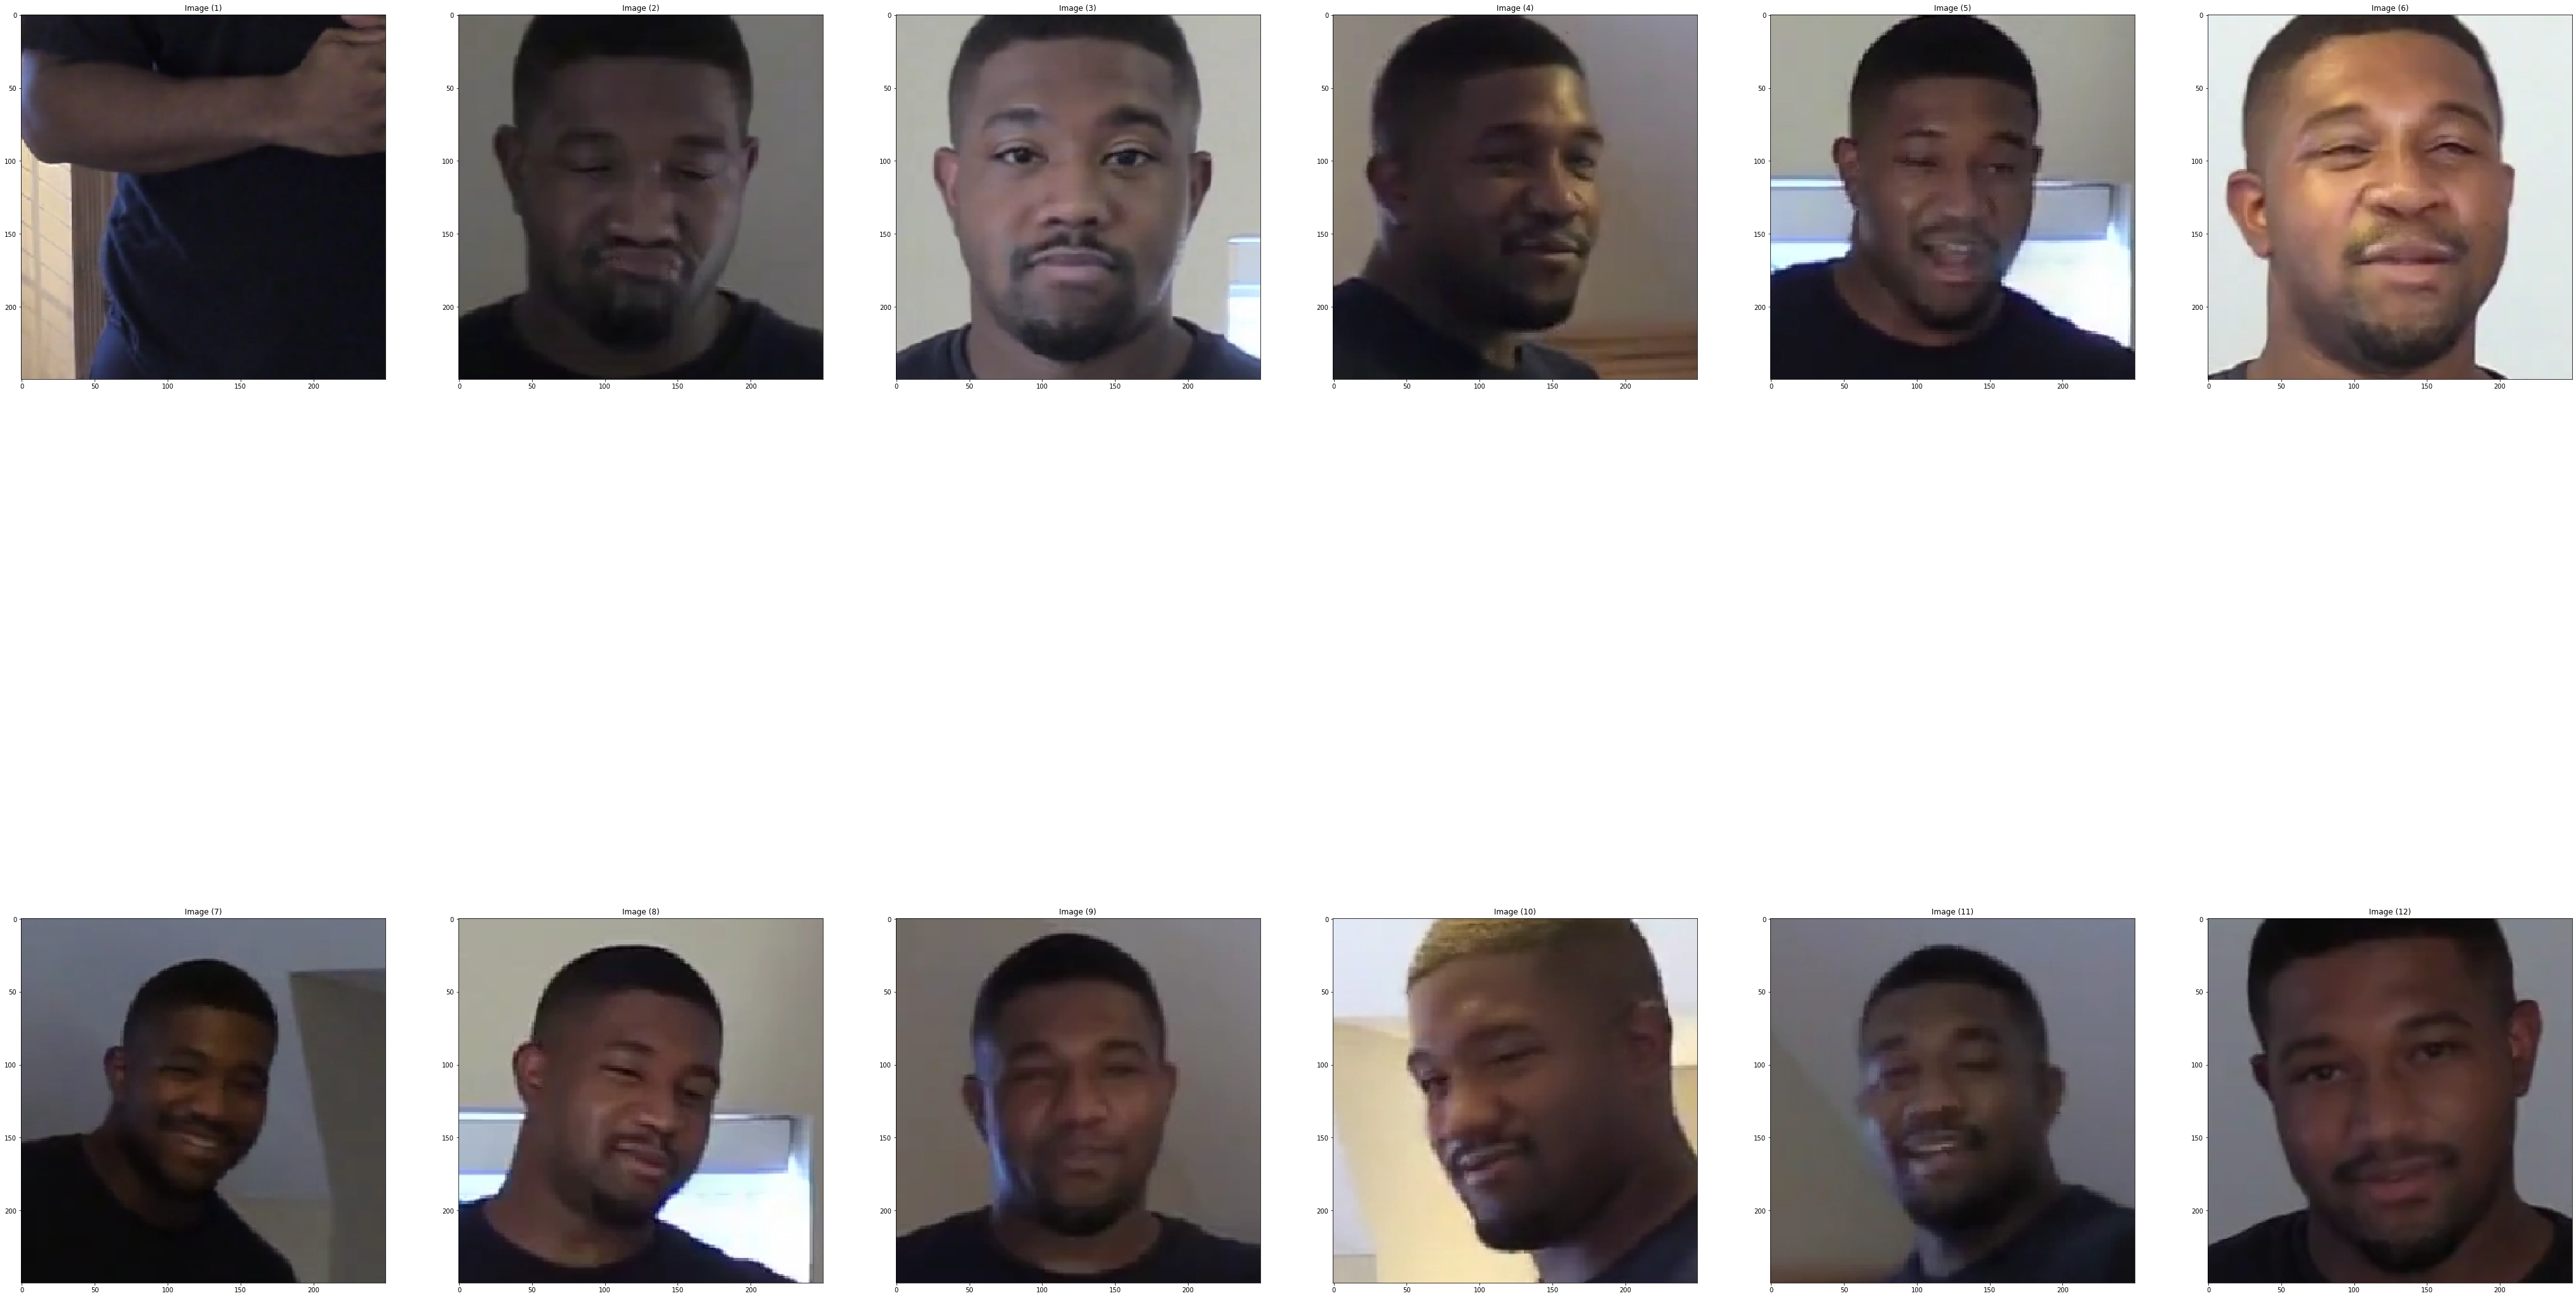

In [31]:
print(f'Frame: {i}')
ith_frames = videos[:,i].numpy()
cols = math.ceil(len(ith_frames)/6)
show_images(ith_frames, cols=cols)
i += 1

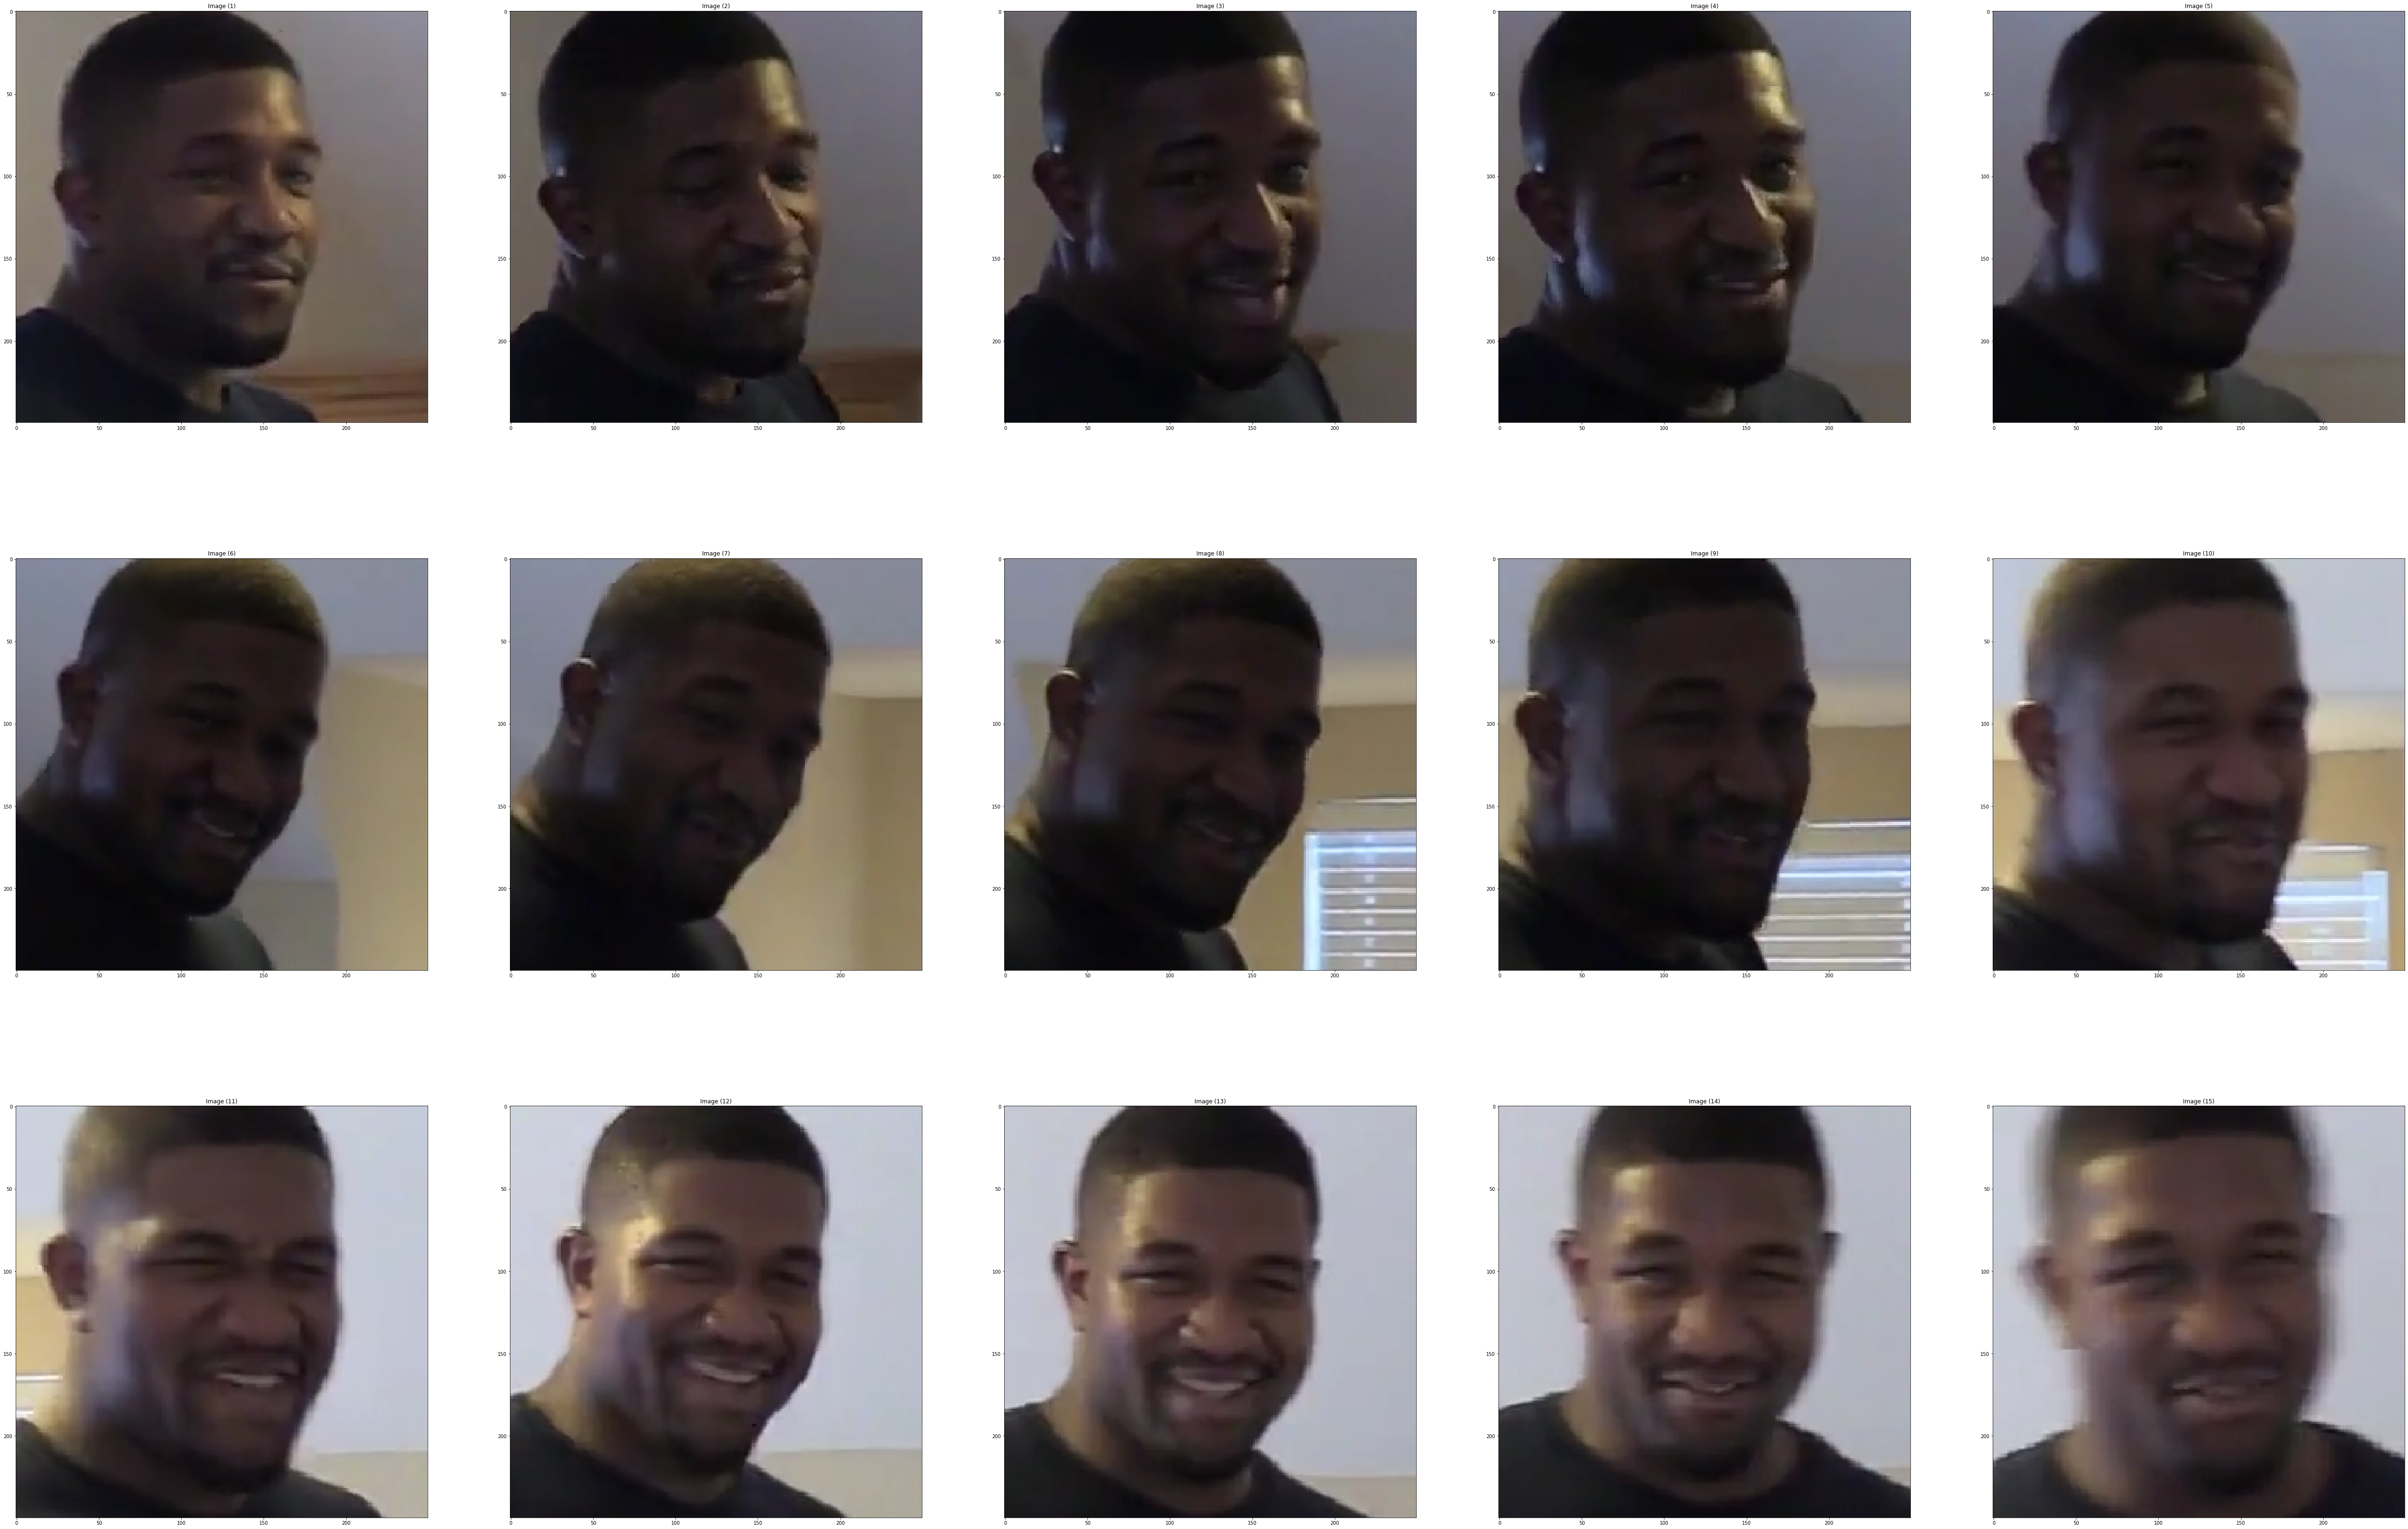

In [32]:
video = videos[3].numpy()
cols = math.ceil(len(video)/6)
show_images(video, cols=cols)